Feature Extraction and Testing and Training set Creation.

In [1]:
import numpy as np 
import pandas as pd 
import librosa 
import os
from sklearn.model_selection import train_test_split
import sklearn
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.callbacks import CSVLogger
from sklearn.preprocessing import OneHotEncoder
import csv
#from keras.callbacks import CSVLogger

#from keras.callbacks import CSVLogger

We will traverse through all the files and create a data frame containg Actor,Gender, Emotion and File Path for each audio files. Then we will use this dataframe to go through all the file path and get the mean mfccs values for each audio file. This mfcc value extracted for each audio file is used to train the model based on emotion associated with each audio file. 

In [2]:
emotion=[]
gender=[]
actor=[]
file_path=[]
for i in os.listdir('./Audio'):
    # print(i)
    for j in os.listdir('./Audio/'+i):
        # print(j)
        # Splitting the File name
        part = j.split('.')[0].split('-')
        emotion.append(int(part[2]))
        actor.append(int(part[6]))
        if int(part[6])%2:
            gender.append('male')
        else:
            gender.append("female")
        file_path.append('./Audio/' + i + '/' + j)

# A dataframe containing all emotion, gender, actor, path
new_df = pd.DataFrame(emotion)
# new_df = new_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
new_df = pd.concat([pd.DataFrame(gender), new_df,pd.DataFrame(actor)], axis=1)
new_df.columns = ['gender','emotion','actor']
new_df = pd.concat([new_df, pd.DataFrame(file_path, columns = ['path'])],axis=1)
print(new_df)


      gender  emotion  actor                                       path
0       male        1      1  ./Audio/Actor_01/03-01-01-01-01-01-01.wav
1       male        1      1  ./Audio/Actor_01/03-01-01-01-01-02-01.wav
2       male        1      1  ./Audio/Actor_01/03-01-01-01-02-01-01.wav
3       male        1      1  ./Audio/Actor_01/03-01-01-01-02-02-01.wav
4       male        2      1  ./Audio/Actor_01/03-01-02-01-01-01-01.wav
...      ...      ...    ...                                        ...
1435  female        8     24  ./Audio/Actor_24/03-01-08-01-02-02-24.wav
1436  female        8     24  ./Audio/Actor_24/03-01-08-02-01-01-24.wav
1437  female        8     24  ./Audio/Actor_24/03-01-08-02-01-02-24.wav
1438  female        8     24  ./Audio/Actor_24/03-01-08-02-02-01-24.wav
1439  female        8     24  ./Audio/Actor_24/03-01-08-02-02-02-24.wav

[1440 rows x 4 columns]


MFCC values for each audio file is extracted here. Generally, librosa.feature.mfcc returns us the mfcc of each audio file and is of shape 20 x 143 . So taking mean for each row using np.mean we get 20 mean mfcc values associated with each audio file. These 20 MFCC value will be used as training parameter.

In [78]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT MFCC and other spectral features
features=np.array([])
for path in new_df.path:
    X, sample_rate = librosa.load(path)
    # MFCC
    # n_fcc is for number of properties in MFCC array
    mfccs = librosa.feature.mfcc(X, sr = sample_rate, hop_length=512, n_mfcc=30)
    # # Get the mean of columns
    mfcc_mean = np.mean(mfccs.T, axis = 0)

    spec_flux = librosa.onset.onset_strength(X, sr=sample_rate)
    spec_flux_mean = np.array([spec_flux.mean()])
    
    # zcrs = librosa.feature.zero_crossing_rate(X)
    # zcrs_mean = np.mean(zcrs, axis=0)

    # chroma = librosa.feature.chroma_stft(X)
    # chroma_mean = np.mean(chroma, axis=0)

    spec_centroid = librosa.feature.spectral_centroid(X, sr=sample_rate)
    spec_centroid_mean = np.mean(spec_centroid.T, axis=0)
    # ZCR, Spectral Centroid, Spectral Flux, SpectralRolloff, MFCC, Chroma, Log Mel spectrumenergy, Harmonic ratio, Modulation spectrumenergy, Pitch
# mfcc, centroid, flux, density, rolloff
    spec_bandwidth = librosa.feature.spectral_bandwidth(X, sr=sample_rate)
    spec_bandwidth_mean = np.mean(spec_bandwidth.T, axis=0)

    spec_contrast = librosa.feature.spectral_contrast(X,sr=sample_rate)
    spec_contrast_mean = np.mean(spec_contrast.T,axis=0)

    spectral_rolloff = librosa.feature.spectral_rolloff(X, sr=sample_rate)
    spectral_rolloff_mean = np.mean(spectral_rolloff.T,axis=0)

    feature = np.concatenate((mfcc_mean, spec_flux_mean, spec_centroid_mean, spec_bandwidth_mean, spectral_rolloff_mean, spec_contrast_mean), axis=0)
    features = np.hstack((features, feature))

In [79]:
with open('Features.csv', 'w', newline = '') as csvfile:
    my_writer = csv.writer(csvfile, delimiter = ',')
    my_writer.writerow(features)

In [103]:
# Use the value stored here without extracting features from above
# Uncomment the following lines
with open('Features.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        feature_csv = row

# features = feature_csv
# print(features.shape)

In [82]:
# 41 = 30(mfcc)+7(contrast)+1(rolloff)+1(centroid)+1(bandwith)+1(flux)
res = np.reshape(features, (1440, 41))
# Dividing dataset in training and testing set
train_X, test_X, train_y, test_y = train_test_split(np.array(res), new_df['emotion'], test_size=0.1, random_state=0)


In [83]:
# # #scaler fit
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)
test_y = np.array(test_y, dtype=int)
train_y = np.array(train_y, dtype=int)

In [84]:
# print(test_y)
# Tranforming labels from single element to 8 element array with 1 at place which is the emotion of the audio
y_train=[]
for i in range(0, train_y.shape[0]):
    x=np.zeros(8)
    x[train_y[i]-1]=1
    y_train.append(x)
y_train=np.array(y_train, dtype=float)
print(y_train)

y_test=[]
for i in range(0, test_y.shape[0]):
    x=np.zeros(8)
    x[test_y[i]-1]=1
    y_test.append(x)
y_test=np.array(y_test, dtype=float)
print(y_test)

test_X=np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))
# y_test=np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))
train_X=np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
# y_train=np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print(train_X.shape,test_X.shape,y_train.shape,y_test.shape)
# test_y=np.reshape(test_y, (432, 1))

[[0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
(1296, 41, 1) (144, 41, 1) (1296, 8) (144, 8)


Data Preprocessing

In [85]:
# Make values between 0 and 1
train_X = (train_X-train_X.mean())/train_X.std()
test_X = (test_X-test_X.mean())/test_X.std()
# train_X=(train_X-train_X.min())/(train_X.max()-train_X.min())
# test_X=(test_X-test_X.min())/(test_X.max()-test_X.min())

In [86]:
# #to plot
def plot_history(history):
  # function to plot accuracy vs epoch
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()
  # print(history.history['loss'])
  plt.plot(history.history['loss'], label='Loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc='lower right')

Now we will define a model, and then run the model on the test train set we have created

In [98]:
from tensorflow.keras import layers,regularizers,models
model = keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters=128, kernel_size=4, input_shape=(train_X[0].shape)),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.MaxPooling1D(2),

                                    tf.keras.layers.Conv1D(filters=64, kernel_size=4),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    # tf.keras.layers.MaxPooling1D(2),

                                    layers.Flatten(),
                                    # layers.Dense(64),
                                    tf.keras.layers.Dense(8 ,activation='softmax')
])

First we will train this MLP model on 'categorical_crossentropy'as loss function, and 'adam' as optimizer and check the accuracy.

In [99]:
# Got less accuracy than 'rmsprop' optimizer
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [100]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 38, 128)           640       
_________________________________________________________________
activation (Activation)      (None, 38, 128)           0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 38, 128)           0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 16, 64)            32832     
_________________________________________________________________
activation_1 (Activation)    (None, 16, 64)            0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 64)           

In [101]:
history=model.fit(train_X, y_train, epochs=300, batch_size=256, validation_data=(test_X, y_test))

===========================] - 0s 62ms/step - loss: 0.3720 - accuracy: 0.8719 - val_loss: 0.9960 - val_accuracy: 0.6597
Epoch 161/300
6/6 [==============================] - 0s 48ms/step - loss: 0.3589 - accuracy: 0.8819 - val_loss: 1.0072 - val_accuracy: 0.6806
Epoch 162/300
6/6 [==============================] - 0s 47ms/step - loss: 0.3595 - accuracy: 0.8812 - val_loss: 1.0104 - val_accuracy: 0.6944
Epoch 163/300
6/6 [==============================] - 0s 47ms/step - loss: 0.3518 - accuracy: 0.8835 - val_loss: 0.9953 - val_accuracy: 0.6806
Epoch 164/300
6/6 [==============================] - 0s 46ms/step - loss: 0.3629 - accuracy: 0.8735 - val_loss: 1.0586 - val_accuracy: 0.6528
Epoch 165/300
6/6 [==============================] - 0s 45ms/step - loss: 0.3425 - accuracy: 0.8858 - val_loss: 0.9982 - val_accuracy: 0.6667
Epoch 166/300
6/6 [==============================] - 0s 49ms/step - loss: 0.3520 - accuracy: 0.8711 - val_loss: 1.0623 - val_accuracy: 0.6667
Epoch 167/300
6/6 [=========

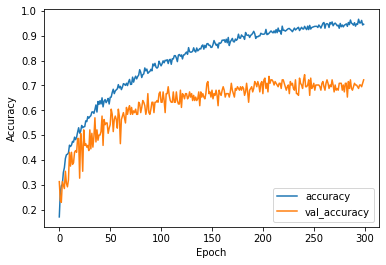

5/5 [==============================] - 0s 10ms/step - loss: 1.0408 - accuracy: 0.7222


[1.0408093929290771, 0.7222222089767456]

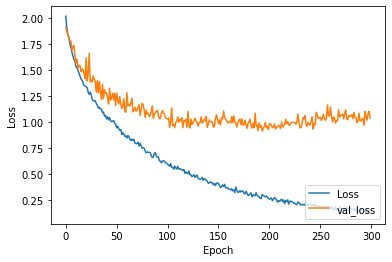

In [102]:
plot_history(history)
model.evaluate(test_X, y_test)